In [52]:
# Import necessary packages
import contextily as ctx
import folium
import geopy.distance
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from operator import itemgetter
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
import random

In [53]:
# Specify the center location (latitude, longtitude)
# Zona Titan
CENTER_LOCATION = (44.413162, 26.163739)

#HQ Courier
HQ_COURIER = (44.387820, 26.168503)

# Specify distance in meters
DIST = 3000

# Specify the number of vehicles
NUM_VEHICLES = 4

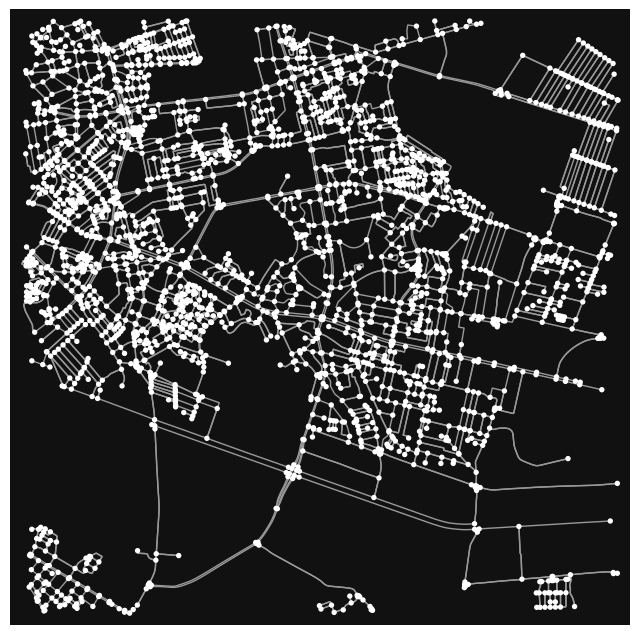

In [54]:
# Get the highway graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
*_, = ox.plot_graph(G)

MultiDiGraph with 2508 nodes and 6016 edges


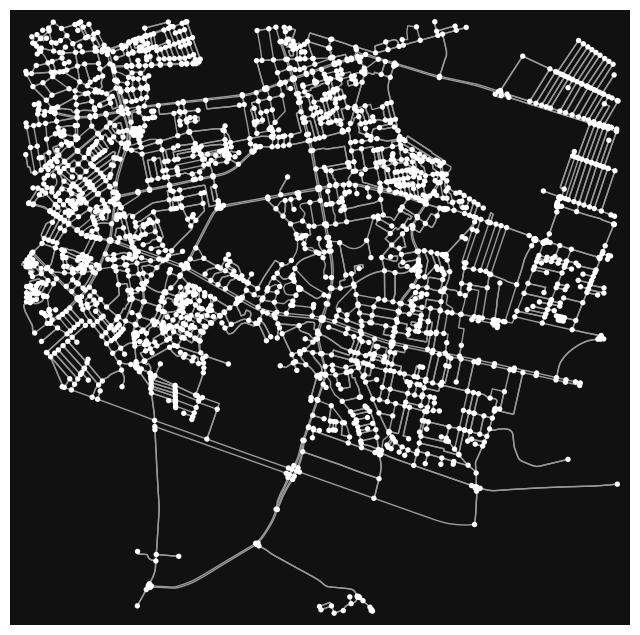

In [55]:
# Remove unreachable nodes from the graph
G = ox.utils_graph.get_largest_component(G, strongly=True)
print(G)
*_, = ox.plot_graph(G)

In [56]:
# Use the nearest node to the center location as the depot
HQ_COURIER = (44.387820, 26.168503)
hq = ox.distance.nearest_nodes(G, HQ_COURIER[1], HQ_COURIER[0])
hq

6529858706

In [57]:
def findBestWayForCourier(G, courier_destinations, hq) :
  # Create a directed graph for path finding
  directed_G = G.to_directed()

  # Create a list to store the nodes in the path
  path_nodes = []

  # Start from HQ_COURIER
  current_location = ox.distance.nearest_nodes(directed_G, hq[1], hq[0])

  # Add HQ_COURIER to the path
  path_nodes.append(current_location)

  # Iterate through the randomly selected edges
  for edge in courier_destinations:
      # Get the target node of the edge
      target_node = edge[1]

      # Find the shortest path from the current location to the target node
      shortest_path = nx.shortest_path(directed_G, source=current_location, target=target_node, weight='length')

      # Add the nodes in the path to the overall path_nodes list
      path_nodes.extend(shortest_path[1:])  # Exclude the starting node as it's already added

      # Update the current location to the target node for the next iteration
      current_location = target_node

  # Find the shortest path back to HQ_COURIER
  shortest_path_back = nx.shortest_path(directed_G, source=current_location, target=path_nodes[0], weight='length')

  # Add the nodes in the return path to the overall path_nodes list
  path_nodes.extend(shortest_path_back[1:])
  return path_nodes

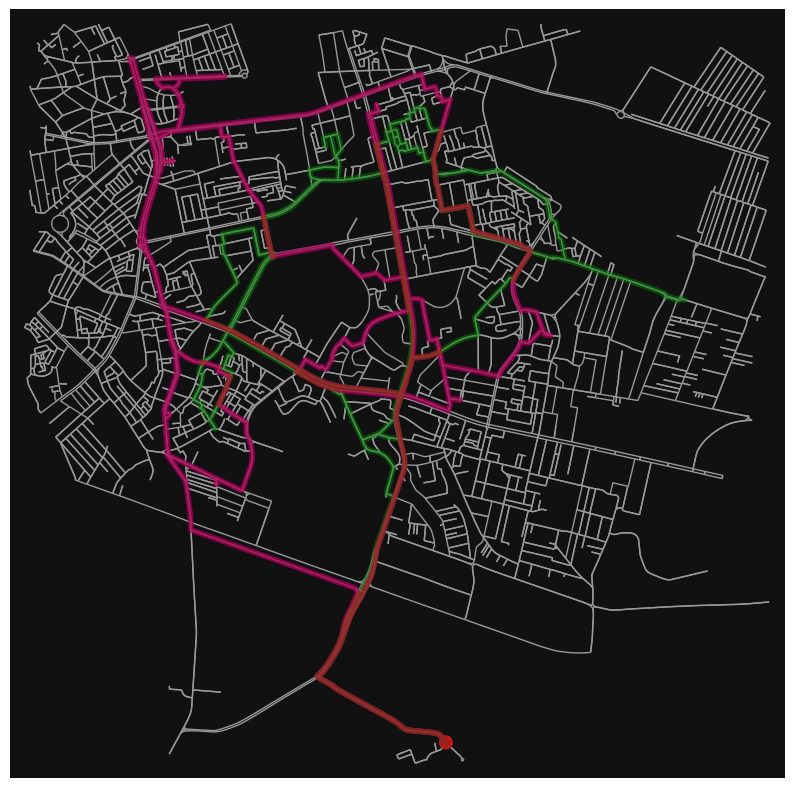

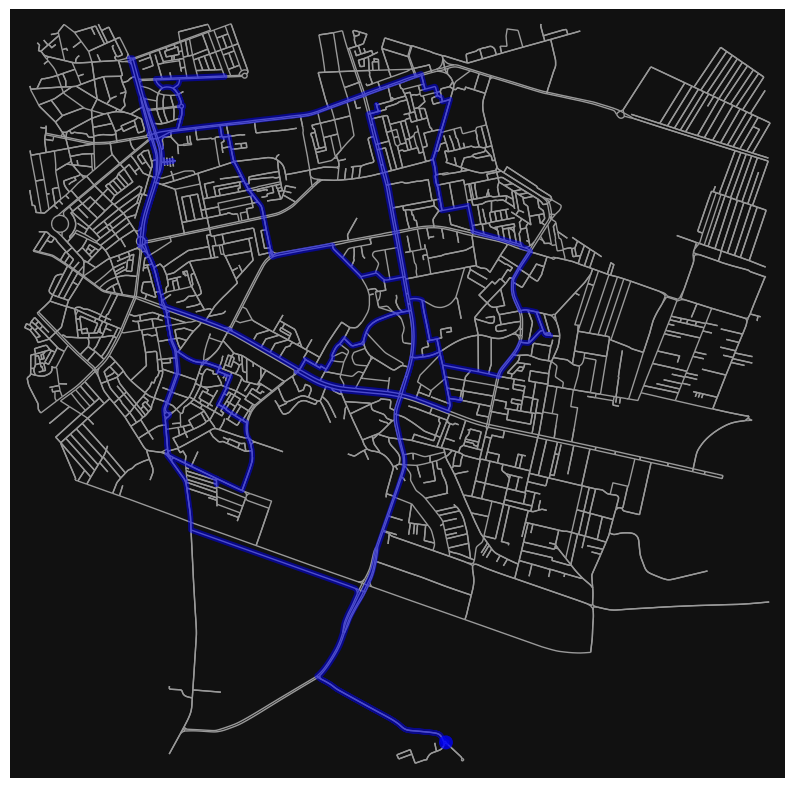

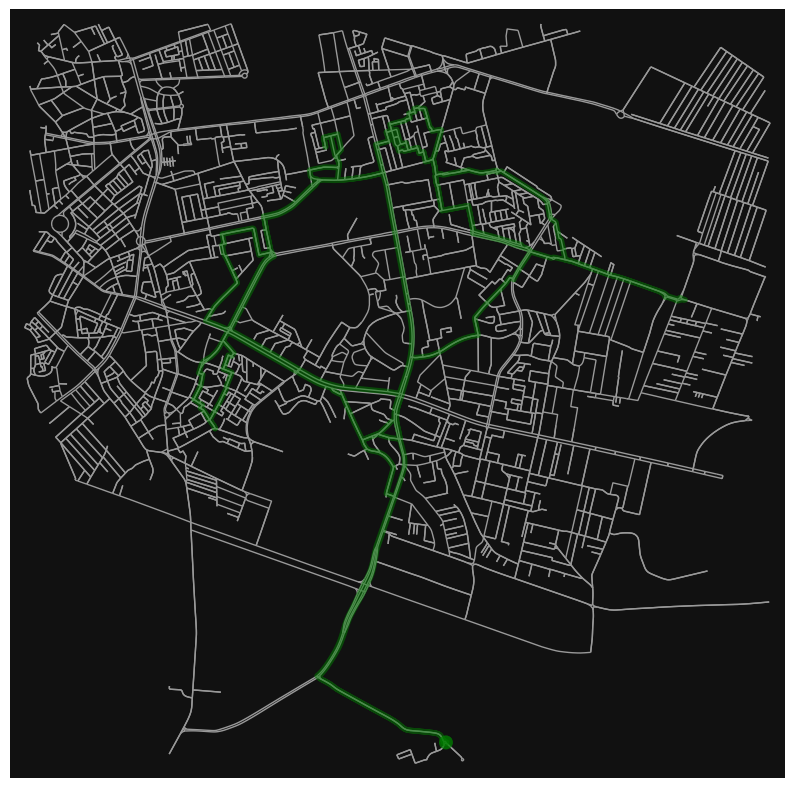

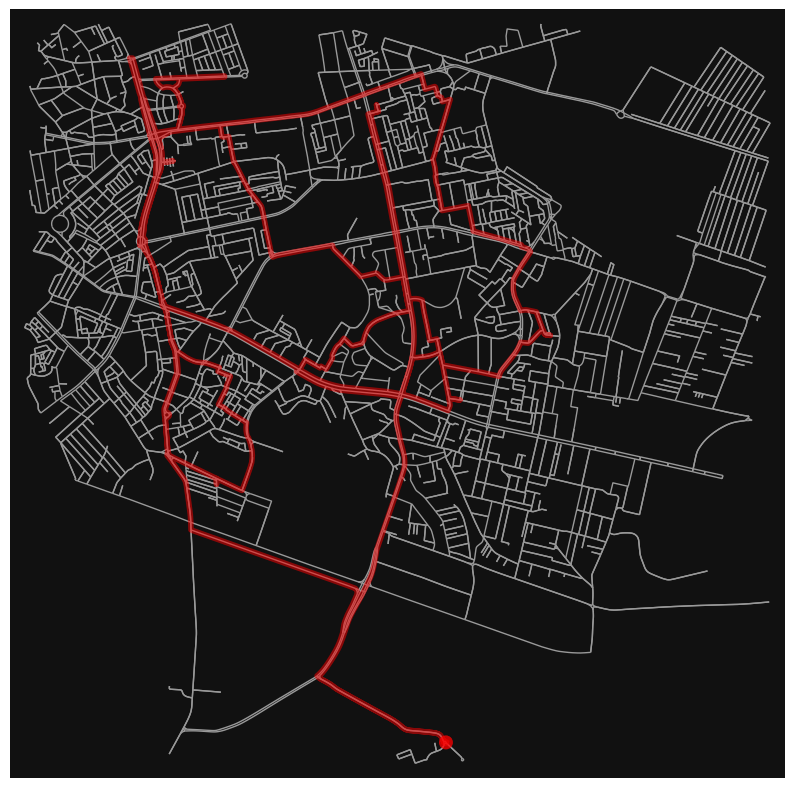

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [58]:
all_nodes = list(G.edges())
courier1_destinations = random.sample(all_nodes, 10)
courier2_destinations = random.sample(all_nodes, 10)
courier3_destinations = random.sample(all_nodes, 10)

path1 = findBestWayForCourier(G, courier1_destinations, HQ_COURIER)
path2 = findBestWayForCourier(G, courier2_destinations, HQ_COURIER)
path3 = findBestWayForCourier(G, courier1_destinations, HQ_COURIER)

# Plot the graph with the routes highlighted in colors and display the plot
ox.plot_graph_routes(
    G,
    routes=[path1, path2, path3],
    route_colors=['blue', 'green', 'red'],
    node_size=0,
    figsize=(10, 10)
)

# Plot all the routes individually
ox.plot_graph_route(G, path1, route_color='blue', node_size=0, figsize=(10, 10))
ox.plot_graph_route(G, path2, route_color='green', node_size=0, figsize=(10, 10))
ox.plot_graph_route(G, path3, route_color='red', node_size=0, figsize=(10, 10))

In [59]:
# Find stops
# will be completed
house_locations_for_courier1 = [
(44.405465, 26.166303),
(44.404320, 26.167647),
(44.403417, 26.171721),
(44.402815, 26.173890),
(44.401620, 26.175245),
(44.400775, 26.179310),
(44.399920, 26.183475),
(44.398325, 26.185730),
(44.397180, 26.187075),
(44.395335, 26.189140),
(44.394490, 26.191395),
(44.393645, 26.195460),
(44.392500, 26.197715)]
house_locations_for_courier2 = [
(44.414739, 26.143783),
(44.412739, 26.143783),
(44.413739, 26.144783),
(44.413739, 26.142783),
(44.414739, 26.142783),
(44.412739, 26.144783),
(44.414739, 26.144783),
(44.412739, 26.142783),
(44.415739, 26.143783),
(44.412739, 26.141783),
(44.414739, 26.141783),
(44.415739, 26.142783),
(44.412739, 26.145783)]
house_locations_for_courier3 = [
(44.424951, 26.144003),
(44.422951, 26.144003),
(44.423951, 26.145003),
(44.423951, 26.143003),
(44.424951, 26.143003),
(44.422951, 26.145003),
(44.424951, 26.145003),
(44.422951, 26.143003),
(44.425951, 26.144003),
(44.422951, 26.142003),
(44.424951, 26.142003),
(44.425951, 26.143003),
(44.422951, 26.146003)
]
house_locations_for_courier4 = [
(44.426232, 26.170183),
(44.424232, 26.170183),
(44.425232, 26.171183),
(44.425232, 26.169183),
(44.426232, 26.169183),
(44.424232, 26.171183),
(44.426232, 26.171183),
(44.424232, 26.169183),
(44.427232, 26.170183),
(44.424232, 26.168183),
(44.426232, 26.168183),
(44.427232, 26.169183),
(44.424232, 26.172183)
]
